# Real Estate Investment Advisor
## Predicting Property Profitability & Future Value

This notebook implements a comprehensive machine learning solution for real estate investment analysis:
- **Classification**: Predict whether a property is a "Good Investment"
- **Regression**: Predict the estimated property price after 5 years

### Project Structure:
1. Data Preprocessing
2. Exploratory Data Analysis (EDA)
3. Feature Engineering
4. Model Development (Classification & Regression)
5. MLflow Experiment Tracking
6. Model Saving for Flask Deployment

## 1. Import Required Libraries

In [1]:
# Data Processing
import pandas as pd
import numpy as np
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay,
                             mean_squared_error, mean_absolute_error, r2_score)
from xgboost import XGBClassifier, XGBRegressor

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn
import mlflow.xgboost

# Model persistence
import joblib
import pickle
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore Dataset

In [2]:
# Load the dataset
df = pd.read_csv('india_housing_prices.csv')

# Display basic information
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumn Names:\n{df.columns.tolist()}")

# Display first few rows
print("\n" + "=" * 60)
print("FIRST 5 ROWS")
print("=" * 60)
df.head()

DATASET OVERVIEW

Dataset Shape: 250000 rows × 23 columns

Column Names:
['ID', 'State', 'City', 'Locality', 'Property_Type', 'BHK', 'Size_in_SqFt', 'Price_in_Lakhs', 'Price_per_SqFt', 'Year_Built', 'Furnished_Status', 'Floor_No', 'Total_Floors', 'Age_of_Property', 'Nearby_Schools', 'Nearby_Hospitals', 'Public_Transport_Accessibility', 'Parking_Space', 'Security', 'Amenities', 'Facing', 'Owner_Type', 'Availability_Status']

FIRST 5 ROWS


,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,Furnished_Status,Floor_No,Total_Floors,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status
0,1,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,Furnished,22,1,35,10,3,High,No,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move
1,2,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,Unfurnished,21,20,17,8,1,Low,No,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction
2,3,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,Semi-furnished,19,27,28,9,8,Low,Yes,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move
3,4,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,Furnished,21,26,34,5,7,High,Yes,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move
4,5,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,Semi-furnished,3,2,23,4,9,Low,No,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move


In [3]:
# Detailed data types and info
print("=" * 60)
print("DATA TYPES AND INFO")
print("=" * 60)
df.info()

DATA TYPES AND INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              250000 non-null  int64  
 1   State                           250000 non-null  object 
 2   City                            250000 non-null  object 
 3   Locality                        250000 non-null  object 
 4   Property_Type                   250000 non-null  object 
 5   BHK                             250000 non-null  int64  
 6   Size_in_SqFt                    250000 non-null  int64  
 7   Price_in_Lakhs                  250000 non-null  float64
 8   Price_per_SqFt                  250000 non-null  float64
 9   Year_Built                      250000 non-null  int64  
 10  Furnished_Status                250000 non-null  object 
 11  Floor_No                        250000 non-null  int64  
 

In [4]:
# Statistical summary
print("=" * 60)
print("STATISTICAL SUMMARY")
print("=" * 60)
df.describe()

STATISTICAL SUMMARY


,ID,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,Floor_No,Total_Floors,Age_of_Property,Nearby_Schools,Nearby_Hospitals
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,125000.500000,2.999396,2749.813216,254.586854,0.130597,2006.520012,14.966800,15.503004,18.479988,5.499860,5.498016
std,72168.927986,1.415521,1300.606954,141.349921,0.130747,9.808575,8.948047,8.671618,9.808575,2.878639,2.871860
min,1.000000,1.000000,500.000000,10.000000,0.000000,1990.000000,0.000000,1.000000,2.000000,1.000000,1.000000
25%,62500.750000,2.000000,1623.000000,132.550000,0.050000,1998.000000,7.000000,8.000000,10.000000,3.000000,3.000000
50%,125000.500000,3.000000,2747.000000,253.870000,0.090000,2007.000000,15.000000,15.000000,18.000000,5.000000,5.000000
75%,187500.250000,4.000000,3874.000000,376.880000,0.160000,2015.000000,23.000000,23.000000,27.000000,8.000000,8.000000
max,250000.000000,5.000000,5000.000000,500.000000,0.990000,2023.000000,30.000000,30.000000,35.000000,10.000000,10.000000


In [5]:
# Categorical columns summary
print("=" * 60)
print("CATEGORICAL COLUMNS UNIQUE VALUES")
print("=" * 60)

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    print(f"\n{col}:")
    print(f"  Unique values: {df[col].nunique()}")
    if df[col].nunique() <= 10:
        print(f"  Values: {df[col].unique().tolist()}")

CATEGORICAL COLUMNS UNIQUE VALUES

State:
  Unique values: 20

City:
  Unique values: 42

Locality:
  Unique values: 500

Property_Type:
  Unique values: 3
  Values: ['Apartment', 'Independent House', 'Villa']

Furnished_Status:
  Unique values: 3
  Values: ['Furnished', 'Unfurnished', 'Semi-furnished']

Public_Transport_Accessibility:
  Unique values: 20

City:
  Unique values: 42

Locality:
  Unique values: 500

Property_Type:
  Unique values: 3
  Values: ['Apartment', 'Independent House', 'Villa']

Furnished_Status:
  Unique values: 3
  Values: ['Furnished', 'Unfurnished', 'Semi-furnished']

Public_Transport_Accessibility:
  Unique values: 3
  Values: ['High', 'Low', 'Medium']

Parking_Space:
  Unique values: 2
  Values: ['No', 'Yes']

Security:
  Unique values: 2
  Values: ['No', 'Yes']

Amenities:
  Unique values: 325

Facing:
  Unique values: 3
  Values: ['High', 'Low', 'Medium']

Parking_Space:
  Unique values: 2
  Values: ['No', 'Yes']

Security:
  Unique values: 2
  Values: ['

## 3. Data Preprocessing

### 3.1 Handle Missing Values and Duplicates

In [6]:
# Check for missing values
print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

missing_values = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
}).sort_values(by='Missing Values', ascending=False)

print(missing_df[missing_df['Missing Values'] > 0])
print(f"\nTotal Missing Values: {missing_values.sum()}")

MISSING VALUES ANALYSIS
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []

Total Missing Values: 0
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []

Total Missing Values: 0


In [7]:
# Handle missing values
# For numerical columns: fill with median
# For categorical columns: fill with mode

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Fill numerical missing values with median
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)
        print(f"Filled {col} with median: {df[col].median()}")

# Fill categorical missing values with mode
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)
        print(f"Filled {col} with mode: {df[col].mode()[0]}")

print(f"\nRemaining missing values: {df.isnull().sum().sum()}")


Remaining missing values: 0


In [8]:
# Check for duplicates
print("=" * 60)
print("DUPLICATES ANALYSIS")
print("=" * 60)

duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows")
    print(f"New dataset shape: {df.shape}")
else:
    print("No duplicate rows found")

DUPLICATES ANALYSIS
Number of duplicate rows: 0
No duplicate rows found
Number of duplicate rows: 0
No duplicate rows found


### 3.2 Feature Engineering - Create New Features

In [9]:
# Create new features
print("=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# 1. Price per Square Foot (already exists, but verify/recalculate)
df['Price_per_SqFt_Calculated'] = (df['Price_in_Lakhs'] * 100000) / df['Size_in_SqFt']
print("✓ Created: Price_per_SqFt_Calculated")

# 2. School Density Score (based on Nearby_Schools)
df['School_Density_Score'] = df['Nearby_Schools'] / df['Nearby_Schools'].max()
print("✓ Created: School_Density_Score")

# 3. Hospital Accessibility Score
df['Hospital_Score'] = df['Nearby_Hospitals'] / df['Nearby_Hospitals'].max()
print("✓ Created: Hospital_Score")

# 4. Infrastructure Score (combining multiple factors)
# Convert Public_Transport_Accessibility to numeric
transport_map = {'Low': 1, 'Medium': 2, 'High': 3}
df['Transport_Score'] = df['Public_Transport_Accessibility'].map(transport_map)

# Create composite Infrastructure Score
df['Infrastructure_Score'] = (
    df['School_Density_Score'] * 0.25 + 
    df['Hospital_Score'] * 0.25 + 
    (df['Transport_Score'] / 3) * 0.25 +
    (df['Security'].map({'Yes': 1, 'No': 0})) * 0.25
)
print("✓ Created: Infrastructure_Score")

# 5. Property Age Category
df['Property_Age_Category'] = pd.cut(
    df['Age_of_Property'], 
    bins=[0, 5, 10, 20, 50], 
    labels=['New', 'Recent', 'Moderate', 'Old']
)
print("✓ Created: Property_Age_Category")

# 6. BHK Category
df['BHK_Category'] = pd.cut(
    df['BHK'], 
    bins=[0, 2, 3, 10], 
    labels=['Small', 'Medium', 'Large']
)
print("✓ Created: BHK_Category")

# 7. Price Category (for analysis)
df['Price_Category'] = pd.qcut(
    df['Price_in_Lakhs'], 
    q=4, 
    labels=['Budget', 'Affordable', 'Premium', 'Luxury']
)
print("✓ Created: Price_Category")

# 8. Is Ready to Move
df['Is_Ready_to_Move'] = (df['Availability_Status'] == 'Ready_to_Move').astype(int)
print("✓ Created: Is_Ready_to_Move")

# 9. Has Parking
df['Has_Parking'] = (df['Parking_Space'] == 'Yes').astype(int)
print("✓ Created: Has_Parking")

# 10. Has Security
df['Has_Security'] = (df['Security'] == 'Yes').astype(int)
print("✓ Created: Has_Security")

# 11. Amenities Count
df['Amenities_Count'] = df['Amenities'].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
print("✓ Created: Amenities_Count")

# 12. Location Premium Score (based on average price per city)
city_avg_price = df.groupby('City')['Price_in_Lakhs'].mean()
df['Location_Premium_Score'] = df['City'].map(city_avg_price) / city_avg_price.max()
print("✓ Created: Location_Premium_Score")

print(f"\nNew dataset shape: {df.shape}")

FEATURE ENGINEERING
✓ Created: Price_per_SqFt_Calculated
✓ Created: School_Density_Score
✓ Created: Hospital_Score
✓ Created: Infrastructure_Score
✓ Created: Property_Age_Category
✓ Created: BHK_Category
✓ Created: Price_Category
✓ Created: Is_Ready_to_Move
✓ Created: Has_Parking
✓ Created: Has_Security
✓ Created: Amenities_Count
✓ Created: Infrastructure_Score
✓ Created: Property_Age_Category
✓ Created: BHK_Category
✓ Created: Price_Category
✓ Created: Is_Ready_to_Move
✓ Created: Has_Parking
✓ Created: Has_Security
✓ Created: Amenities_Count
✓ Created: Location_Premium_Score

New dataset shape: (250000, 36)
✓ Created: Location_Premium_Score

New dataset shape: (250000, 36)


### 3.3 Create Target Variables

#### Regression Target: Future_Price_5Y
Using location-based growth rates for more realistic predictions.

#### Classification Target: Good_Investment
Using multi-factor scoring approach.

In [10]:
# ============================================================
# CREATE TARGET VARIABLE 1: FUTURE PRICE (5 YEARS)
# ============================================================

# Define city-based growth rates (annual appreciation rates)
# Metro cities have higher growth, tier-2/3 cities have moderate growth
city_growth_rates = {
    # Metro Cities - Higher growth
    'Mumbai': 0.10, 'New Delhi': 0.10, 'Bangalore': 0.12, 'Hyderabad': 0.11,
    'Chennai': 0.09, 'Kolkata': 0.08, 'Pune': 0.10, 'Ahmedabad': 0.09,
    # Tier-2 Cities - Moderate growth
    'Jaipur': 0.08, 'Lucknow': 0.07, 'Noida': 0.11, 'Gurugram': 0.10,
    'Chandigarh': 0.08, 'Indore': 0.07, 'Bhopal': 0.06, 'Nagpur': 0.06,
    'Coimbatore': 0.07, 'Kochi': 0.08, 'Visakhapatnam': 0.07, 'Mysore': 0.07,
    # Tier-3 Cities - Lower growth  
    'default': 0.06  # Default rate for cities not in the list
}

# Property type adjustment factors
property_type_factor = {
    'Apartment': 1.0,
    'Villa': 1.15,
    'Independent House': 1.05,
    'default': 1.0
}

# Additional factors
def calculate_future_price(row):
    # Get base growth rate for city
    base_rate = city_growth_rates.get(row['City'], city_growth_rates['default'])
    
    # Adjust for property type
    prop_factor = property_type_factor.get(row['Property_Type'], property_type_factor['default'])
    
    # Adjust for infrastructure
    infra_boost = row['Infrastructure_Score'] * 0.02  # Up to 2% extra
    
    # Adjust for ready-to-move status
    rtm_boost = 0.01 if row['Is_Ready_to_Move'] == 1 else 0
    
    # Calculate final growth rate
    final_rate = base_rate * prop_factor + infra_boost + rtm_boost
    
    # Calculate future price: P * (1 + r)^t where t=5 years
    future_price = row['Price_in_Lakhs'] * ((1 + final_rate) ** 5)
    
    return round(future_price, 2)

df['Future_Price_5Y'] = df.apply(calculate_future_price, axis=1)

print("=" * 60)
print("TARGET VARIABLE 1: FUTURE PRICE (5 YEARS)")
print("=" * 60)
print(f"\nCurrent Price Statistics:")
print(df['Price_in_Lakhs'].describe())
print(f"\nFuture Price (5Y) Statistics:")
print(df['Future_Price_5Y'].describe())
print(f"\nAverage Appreciation: {((df['Future_Price_5Y'].mean() / df['Price_in_Lakhs'].mean()) - 1) * 100:.2f}%")

TARGET VARIABLE 1: FUTURE PRICE (5 YEARS)

Current Price Statistics:
count    250000.000000
mean        254.586854
std         141.349921
min          10.000000
25%         132.550000
50%         253.870000
75%         376.880000
max         500.000000
Name: Price_in_Lakhs, dtype: float64

Future Price (5Y) Statistics:
count    250000.000000
mean        394.442608
std         222.863895
min          13.660000
25%         203.780000
50%         390.565000
75%         580.290000
max        1071.240000
Name: Future_Price_5Y, dtype: float64

Average Appreciation: 54.93%


In [12]:
# ============================================================
# CREATE TARGET VARIABLE 2: GOOD INVESTMENT (Classification)
# ============================================================
# OPTIMIZED VERSION: Pre-compute medians to avoid slow row-by-row calculations

print("Creating Good Investment target variable...")
print("Pre-computing city-level statistics...")

# Pre-compute city medians (MUCH faster than computing per row)
city_price_median = df.groupby('City')['Price_in_Lakhs'].transform('median')
city_ppsf_median = df.groupby('City')['Price_per_SqFt_Calculated'].transform('median')

print("Calculating investment scores using vectorized operations...")

# Initialize score
df['Investment_Score'] = 0

# Factor 1: Price vs Median (25 points max)
df['Investment_Score'] += np.where(df['Price_in_Lakhs'] <= city_price_median, 25,
                                    np.where(df['Price_in_Lakhs'] <= city_price_median * 1.2, 15, 5))

# Factor 2: Price per Sq Ft vs Median (20 points max)
df['Investment_Score'] += np.where(df['Price_per_SqFt_Calculated'] <= city_ppsf_median, 20,
                                    np.where(df['Price_per_SqFt_Calculated'] <= city_ppsf_median * 1.2, 10, 3))

# Factor 3: BHK (15 points max)
df['Investment_Score'] += np.where(df['BHK'] >= 3, 15,
                                    np.where(df['BHK'] == 2, 10, 5))

# Factor 4: Ready to Move (10 points max)
df['Investment_Score'] += np.where(df['Is_Ready_to_Move'] == 1, 10, 3)

# Factor 5: Infrastructure Score (15 points max)
df['Investment_Score'] += df['Infrastructure_Score'] * 15

# Factor 6: Property Age (10 points max)
df['Investment_Score'] += np.where(df['Age_of_Property'] <= 5, 10,
                                    np.where(df['Age_of_Property'] <= 10, 7,
                                             np.where(df['Age_of_Property'] <= 20, 4, 2)))

# Factor 7: Amenities (5 points max)
df['Investment_Score'] += np.where(df['Amenities_Count'] >= 4, 5,
                                    np.where(df['Amenities_Count'] >= 2, 3, 1))

# Create binary classification target (threshold = 50)
df['Good_Investment'] = (df['Investment_Score'] >= 50).astype(int)

print("=" * 60)
print("TARGET VARIABLE 2: GOOD INVESTMENT (Classification)")
print("=" * 60)
print(f"\nInvestment Score Statistics:")
print(df['Investment_Score'].describe())
print(f"\nGood Investment Distribution:")
print(df['Good_Investment'].value_counts())
print(f"\nPercentage of Good Investments: {df['Good_Investment'].mean() * 100:.2f}%")

Creating Good Investment target variable...
Pre-computing city-level statistics...
Calculating investment scores using vectorized operations...
TARGET VARIABLE 2: GOOD INVESTMENT (Classification)

Investment Score Statistics:
count    250000.000000
mean         62.883645
std          16.961159
min          21.375000
25%          47.750000
50%          64.250000
75%          77.875000
max         100.000000
Name: Investment_Score, dtype: float64

Good Investment Distribution:
Good_Investment
1    177360
0     72640
Name: count, dtype: int64

Percentage of Good Investments: 70.94%


### 3.4 Encode Categorical Features

In [13]:
# ============================================================
# ENCODE CATEGORICAL FEATURES
# ============================================================

# Initialize label encoders dictionary to save for Flask app
label_encoders = {}

# Columns to encode
categorical_to_encode = ['State', 'City', 'Locality', 'Property_Type', 'Furnished_Status', 
                         'Facing', 'Owner_Type', 'Availability_Status', 
                         'Property_Age_Category', 'BHK_Category', 'Price_Category']

print("=" * 60)
print("ENCODING CATEGORICAL FEATURES")
print("=" * 60)

for col in categorical_to_encode:
    if col in df.columns:
        le = LabelEncoder()
        df[f'{col}_Encoded'] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        print(f"✓ Encoded: {col} -> {col}_Encoded ({len(le.classes_)} classes)")

print(f"\nTotal encoders created: {len(label_encoders)}")

ENCODING CATEGORICAL FEATURES
✓ Encoded: State -> State_Encoded (20 classes)
✓ Encoded: City -> City_Encoded (42 classes)
✓ Encoded: Locality -> Locality_Encoded (500 classes)
✓ Encoded: Property_Type -> Property_Type_Encoded (3 classes)
✓ Encoded: Furnished_Status -> Furnished_Status_Encoded (3 classes)
✓ Encoded: Facing -> Facing_Encoded (4 classes)
✓ Encoded: Owner_Type -> Owner_Type_Encoded (3 classes)
✓ Encoded: Availability_Status -> Availability_Status_Encoded (2 classes)
✓ Encoded: Property_Age_Category -> Property_Age_Category_Encoded (4 classes)
✓ Encoded: BHK_Category -> BHK_Category_Encoded (3 classes)
✓ Encoded: Price_Category -> Price_Category_Encoded (4 classes)

Total encoders created: 11
✓ Encoded: Property_Age_Category -> Property_Age_Category_Encoded (4 classes)
✓ Encoded: BHK_Category -> BHK_Category_Encoded (3 classes)
✓ Encoded: Price_Category -> Price_Category_Encoded (4 classes)

Total encoders created: 11


### 3.5 Feature Scaling and Normalization

In [14]:
# ============================================================
# FEATURE SCALING
# ============================================================

# Define features for modeling
feature_columns = [
    'BHK', 'Size_in_SqFt', 'Price_in_Lakhs', 'Year_Built', 'Floor_No', 
    'Total_Floors', 'Age_of_Property', 'Nearby_Schools', 'Nearby_Hospitals',
    'Price_per_SqFt_Calculated', 'School_Density_Score', 'Hospital_Score',
    'Transport_Score', 'Infrastructure_Score', 'Is_Ready_to_Move', 
    'Has_Parking', 'Has_Security', 'Amenities_Count', 'Location_Premium_Score',
    'State_Encoded', 'City_Encoded', 'Property_Type_Encoded', 
    'Furnished_Status_Encoded', 'Owner_Type_Encoded'
]

# Ensure all feature columns exist
feature_columns = [col for col in feature_columns if col in df.columns]

print("=" * 60)
print("FEATURE SCALING")
print("=" * 60)
print(f"\nFeatures selected for modeling: {len(feature_columns)}")
print(feature_columns)

# Create a copy of the dataframe for modeling
df_model = df[feature_columns].copy()

# Initialize and fit scaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_model),
    columns=feature_columns,
    index=df_model.index
)

print(f"\n✓ Features scaled using StandardScaler")
print(f"Scaled data shape: {df_scaled.shape}")

FEATURE SCALING

Features selected for modeling: 24
['BHK', 'Size_in_SqFt', 'Price_in_Lakhs', 'Year_Built', 'Floor_No', 'Total_Floors', 'Age_of_Property', 'Nearby_Schools', 'Nearby_Hospitals', 'Price_per_SqFt_Calculated', 'School_Density_Score', 'Hospital_Score', 'Transport_Score', 'Infrastructure_Score', 'Is_Ready_to_Move', 'Has_Parking', 'Has_Security', 'Amenities_Count', 'Location_Premium_Score', 'State_Encoded', 'City_Encoded', 'Property_Type_Encoded', 'Furnished_Status_Encoded', 'Owner_Type_Encoded']

✓ Features scaled using StandardScaler
Scaled data shape: (250000, 24)


## 4. Exploratory Data Analysis (EDA)

### 4.1 Price Trends by City

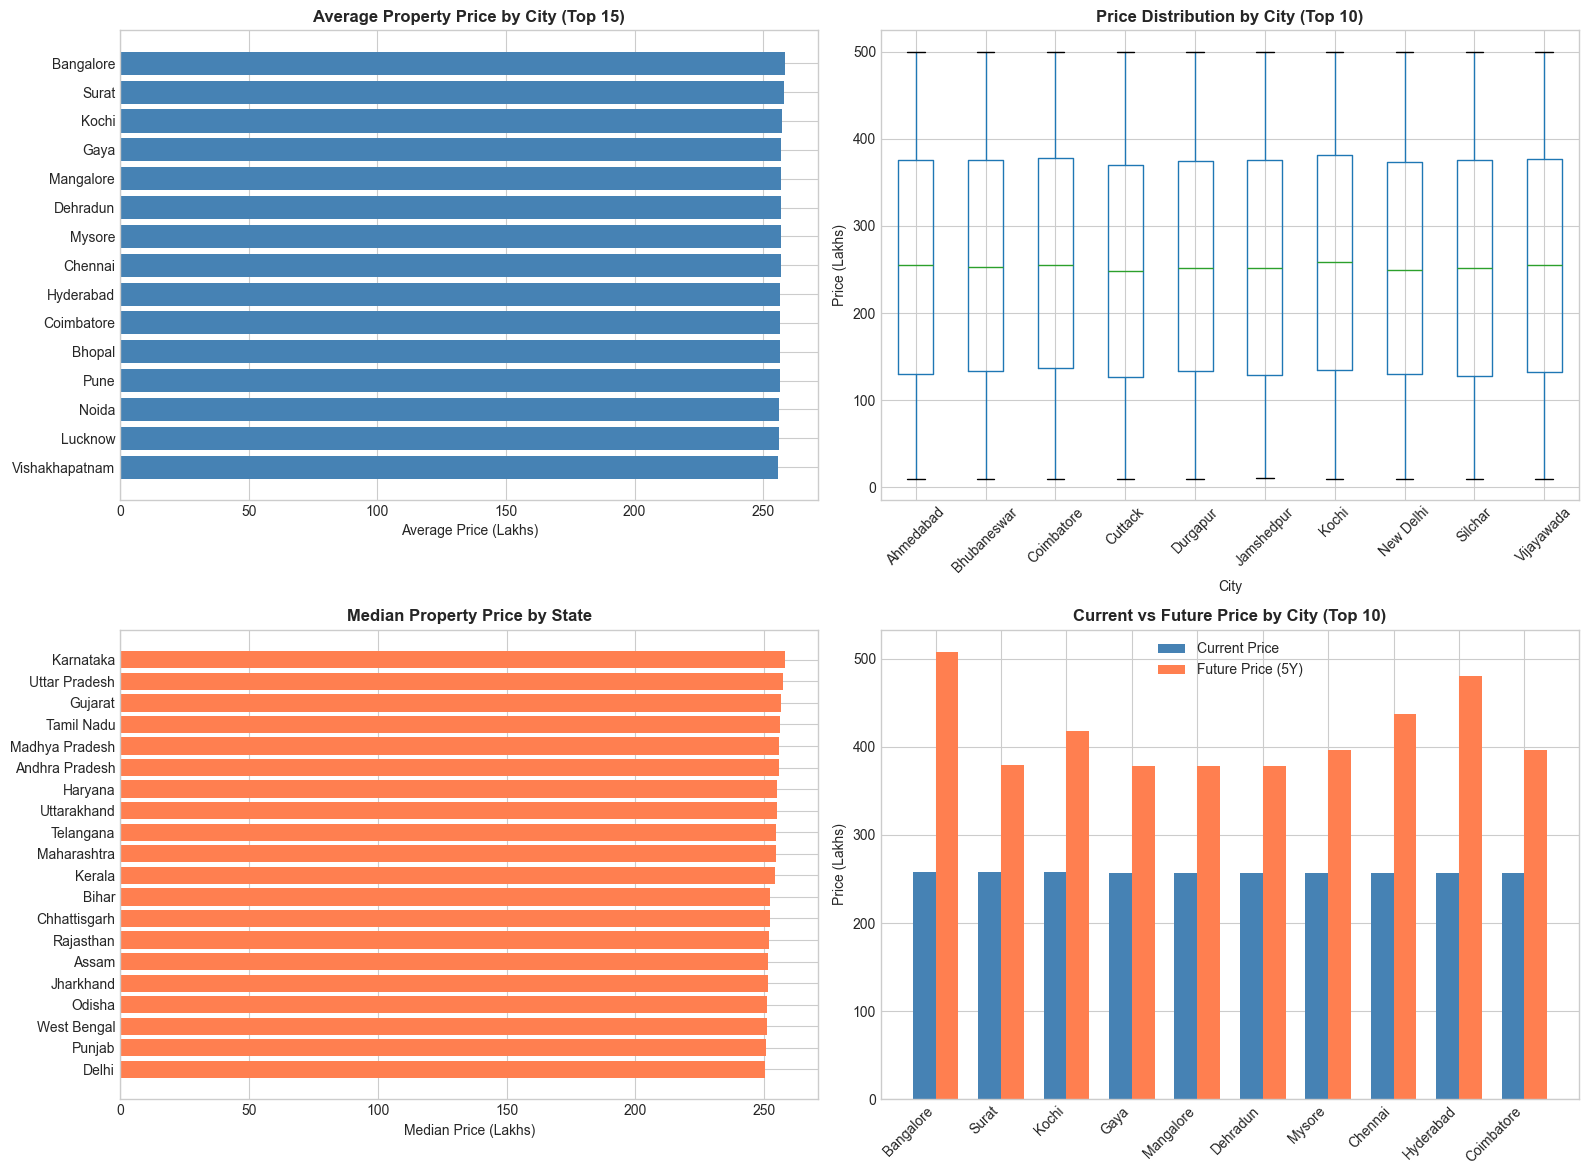

In [15]:
# ============================================================
# PRICE TRENDS BY CITY
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Average Price by City (Top 15)
city_avg_price = df.groupby('City')['Price_in_Lakhs'].mean().sort_values(ascending=False).head(15)
axes[0, 0].barh(city_avg_price.index, city_avg_price.values, color='steelblue')
axes[0, 0].set_xlabel('Average Price (Lakhs)')
axes[0, 0].set_title('Average Property Price by City (Top 15)', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()

# 2. Price Distribution Box Plot by City (Top 10)
top_cities = df['City'].value_counts().head(10).index
df_top_cities = df[df['City'].isin(top_cities)]
df_top_cities.boxplot(column='Price_in_Lakhs', by='City', ax=axes[0, 1], rot=45)
axes[0, 1].set_title('Price Distribution by City (Top 10)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('City')
axes[0, 1].set_ylabel('Price (Lakhs)')
plt.suptitle('')

# 3. Median Price by State
state_median_price = df.groupby('State')['Price_in_Lakhs'].median().sort_values(ascending=False)
axes[1, 0].barh(state_median_price.index, state_median_price.values, color='coral')
axes[1, 0].set_xlabel('Median Price (Lakhs)')
axes[1, 0].set_title('Median Property Price by State', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()

# 4. Price vs Future Price by City
city_comparison = df.groupby('City').agg({
    'Price_in_Lakhs': 'mean',
    'Future_Price_5Y': 'mean'
}).sort_values('Price_in_Lakhs', ascending=False).head(10)

x = np.arange(len(city_comparison.index))
width = 0.35
axes[1, 1].bar(x - width/2, city_comparison['Price_in_Lakhs'], width, label='Current Price', color='steelblue')
axes[1, 1].bar(x + width/2, city_comparison['Future_Price_5Y'], width, label='Future Price (5Y)', color='coral')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(city_comparison.index, rotation=45, ha='right')
axes[1, 1].set_ylabel('Price (Lakhs)')
axes[1, 1].set_title('Current vs Future Price by City (Top 10)', fontsize=12, fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### 4.2 Correlation Analysis

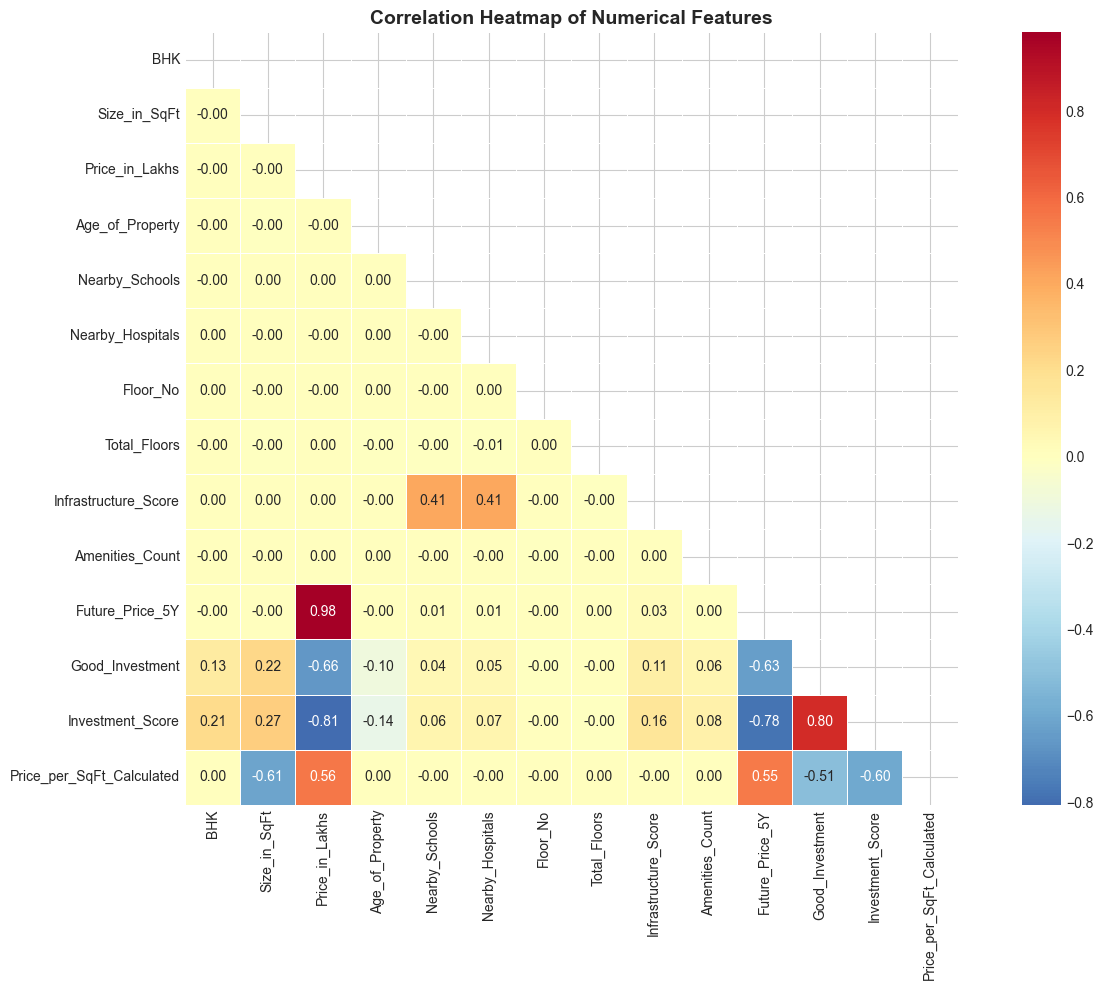

TOP CORRELATIONS WITH TARGET VARIABLES

Correlations with Good_Investment:
Investment_Score        0.798564
Size_in_SqFt            0.223205
BHK                     0.128831
Infrastructure_Score    0.108572
Amenities_Count         0.058407
Name: Good_Investment, dtype: float64

Correlations with Future_Price_5Y:
Price_in_Lakhs               0.982760
Price_per_SqFt_Calculated    0.546123
Infrastructure_Score         0.030560
Nearby_Schools               0.012185
Nearby_Hospitals             0.009273
Name: Future_Price_5Y, dtype: float64


In [16]:
# ============================================================
# CORRELATION ANALYSIS
# ============================================================

# Select numerical columns for correlation
numerical_cols_for_corr = ['BHK', 'Size_in_SqFt', 'Price_in_Lakhs', 'Age_of_Property', 
                           'Nearby_Schools', 'Nearby_Hospitals', 'Floor_No', 'Total_Floors',
                           'Infrastructure_Score', 'Amenities_Count', 'Future_Price_5Y', 
                           'Good_Investment', 'Investment_Score', 'Price_per_SqFt_Calculated']

corr_cols = [col for col in numerical_cols_for_corr if col in df.columns]
correlation_matrix = df[corr_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print top correlations with target variables
print("=" * 60)
print("TOP CORRELATIONS WITH TARGET VARIABLES")
print("=" * 60)
print("\nCorrelations with Good_Investment:")
print(correlation_matrix['Good_Investment'].sort_values(ascending=False)[1:6])
print("\nCorrelations with Future_Price_5Y:")
print(correlation_matrix['Future_Price_5Y'].sort_values(ascending=False)[1:6])

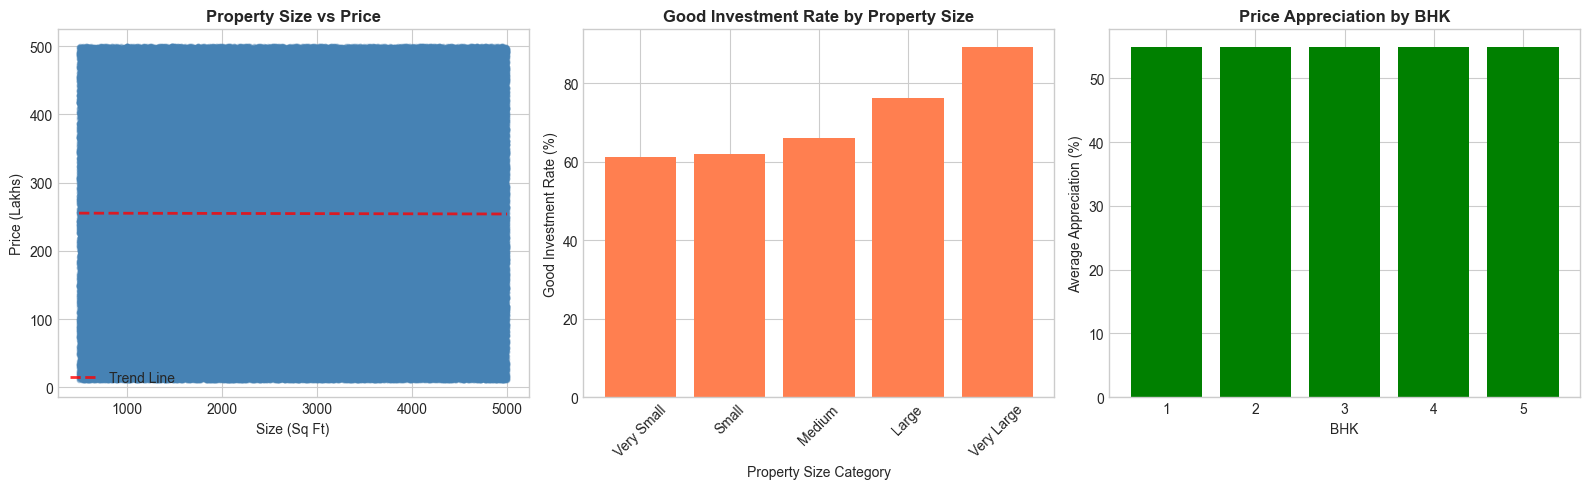

In [17]:
# Area vs Investment Return Analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Size vs Price scatter plot
axes[0].scatter(df['Size_in_SqFt'], df['Price_in_Lakhs'], alpha=0.3, c='steelblue', s=10)
axes[0].set_xlabel('Size (Sq Ft)')
axes[0].set_ylabel('Price (Lakhs)')
axes[0].set_title('Property Size vs Price', fontsize=12, fontweight='bold')

# Add regression line
z = np.polyfit(df['Size_in_SqFt'], df['Price_in_Lakhs'], 1)
p = np.poly1d(z)
axes[0].plot(sorted(df['Size_in_SqFt']), p(sorted(df['Size_in_SqFt'])), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend Line')
axes[0].legend()

# 2. Size vs Good Investment
size_bins = pd.qcut(df['Size_in_SqFt'], q=5, labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'])
investment_by_size = df.groupby(size_bins)['Good_Investment'].mean() * 100
axes[1].bar(investment_by_size.index, investment_by_size.values, color='coral')
axes[1].set_xlabel('Property Size Category')
axes[1].set_ylabel('Good Investment Rate (%)')
axes[1].set_title('Good Investment Rate by Property Size', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

# 3. BHK vs Future Price Appreciation
appreciation = ((df['Future_Price_5Y'] - df['Price_in_Lakhs']) / df['Price_in_Lakhs']) * 100
df['Appreciation_Percent'] = appreciation
bhk_appreciation = df.groupby('BHK')['Appreciation_Percent'].mean()
axes[2].bar(bhk_appreciation.index.astype(str), bhk_appreciation.values, color='green')
axes[2].set_xlabel('BHK')
axes[2].set_ylabel('Average Appreciation (%)')
axes[2].set_title('Price Appreciation by BHK', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 4.3 Impact of Various Factors on Investment Classification

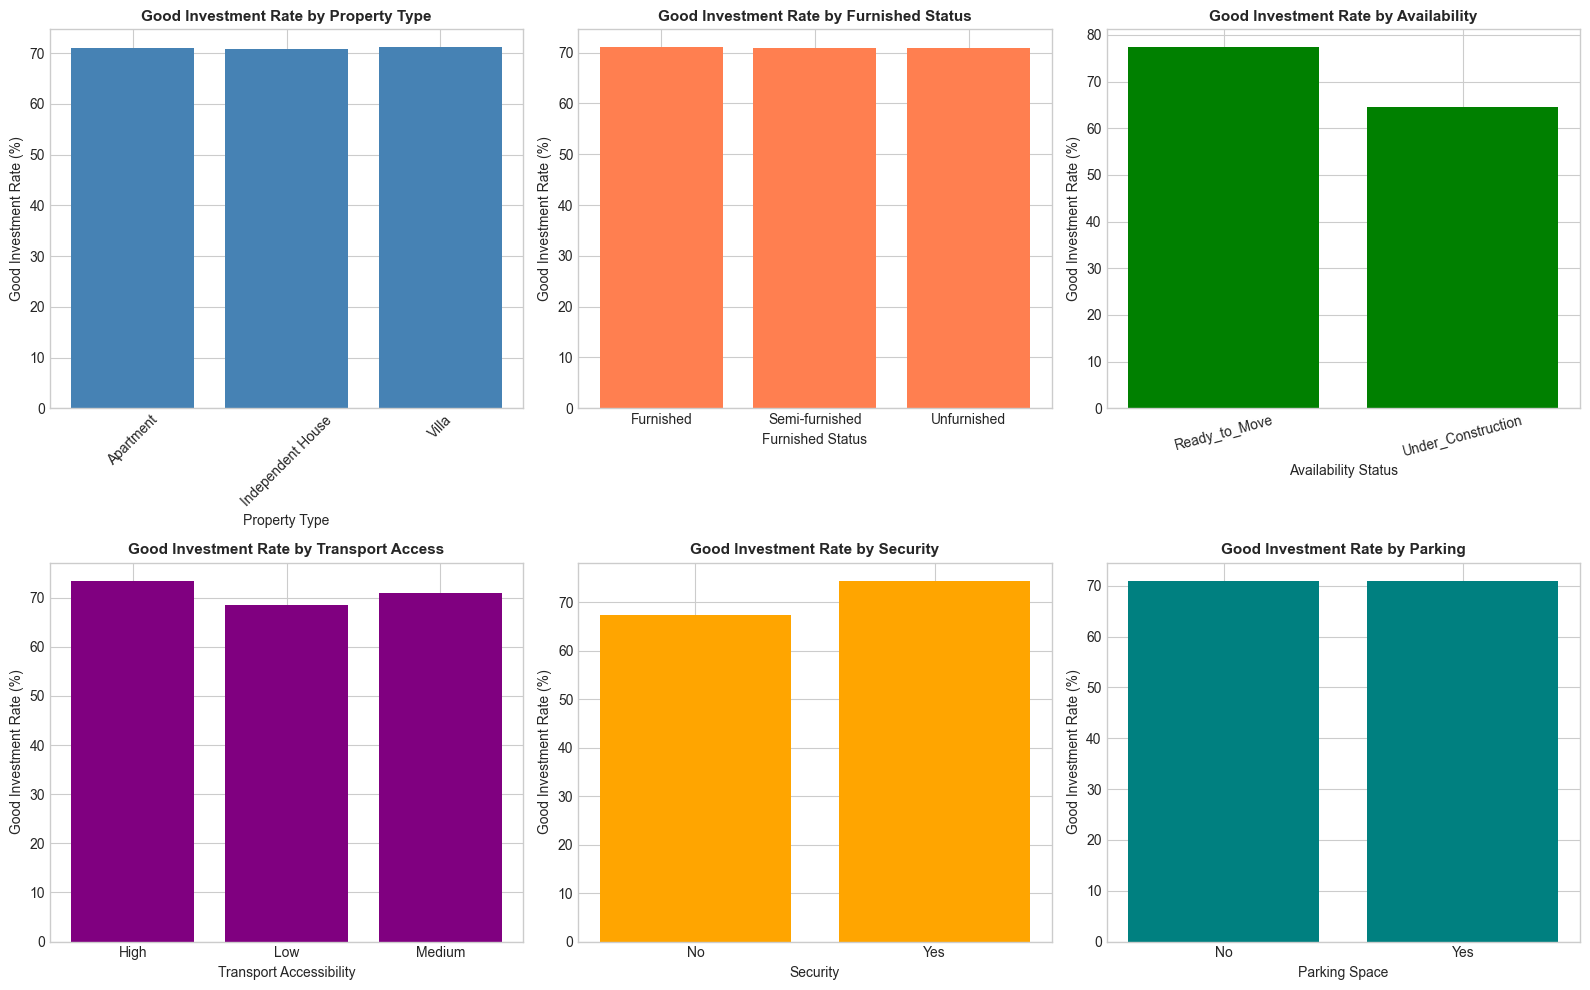

In [18]:
# ============================================================
# IMPACT OF VARIOUS FACTORS ON GOOD INVESTMENT
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Property Type vs Good Investment
prop_type_investment = df.groupby('Property_Type')['Good_Investment'].mean() * 100
axes[0, 0].bar(prop_type_investment.index, prop_type_investment.values, color='steelblue')
axes[0, 0].set_xlabel('Property Type')
axes[0, 0].set_ylabel('Good Investment Rate (%)')
axes[0, 0].set_title('Good Investment Rate by Property Type', fontsize=11, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Furnished Status vs Good Investment
furnished_investment = df.groupby('Furnished_Status')['Good_Investment'].mean() * 100
axes[0, 1].bar(furnished_investment.index, furnished_investment.values, color='coral')
axes[0, 1].set_xlabel('Furnished Status')
axes[0, 1].set_ylabel('Good Investment Rate (%)')
axes[0, 1].set_title('Good Investment Rate by Furnished Status', fontsize=11, fontweight='bold')

# 3. Availability Status vs Good Investment
avail_investment = df.groupby('Availability_Status')['Good_Investment'].mean() * 100
axes[0, 2].bar(avail_investment.index, avail_investment.values, color='green')
axes[0, 2].set_xlabel('Availability Status')
axes[0, 2].set_ylabel('Good Investment Rate (%)')
axes[0, 2].set_title('Good Investment Rate by Availability', fontsize=11, fontweight='bold')
axes[0, 2].tick_params(axis='x', rotation=15)

# 4. Transport Accessibility vs Good Investment
transport_investment = df.groupby('Public_Transport_Accessibility')['Good_Investment'].mean() * 100
axes[1, 0].bar(transport_investment.index, transport_investment.values, color='purple')
axes[1, 0].set_xlabel('Transport Accessibility')
axes[1, 0].set_ylabel('Good Investment Rate (%)')
axes[1, 0].set_title('Good Investment Rate by Transport Access', fontsize=11, fontweight='bold')

# 5. Security vs Good Investment
security_investment = df.groupby('Security')['Good_Investment'].mean() * 100
axes[1, 1].bar(security_investment.index, security_investment.values, color='orange')
axes[1, 1].set_xlabel('Security')
axes[1, 1].set_ylabel('Good Investment Rate (%)')
axes[1, 1].set_title('Good Investment Rate by Security', fontsize=11, fontweight='bold')

# 6. Parking vs Good Investment
parking_investment = df.groupby('Parking_Space')['Good_Investment'].mean() * 100
axes[1, 2].bar(parking_investment.index, parking_investment.values, color='teal')
axes[1, 2].set_xlabel('Parking Space')
axes[1, 2].set_ylabel('Good Investment Rate (%)')
axes[1, 2].set_title('Good Investment Rate by Parking', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### 4.4 Infrastructure Score vs Resale Value

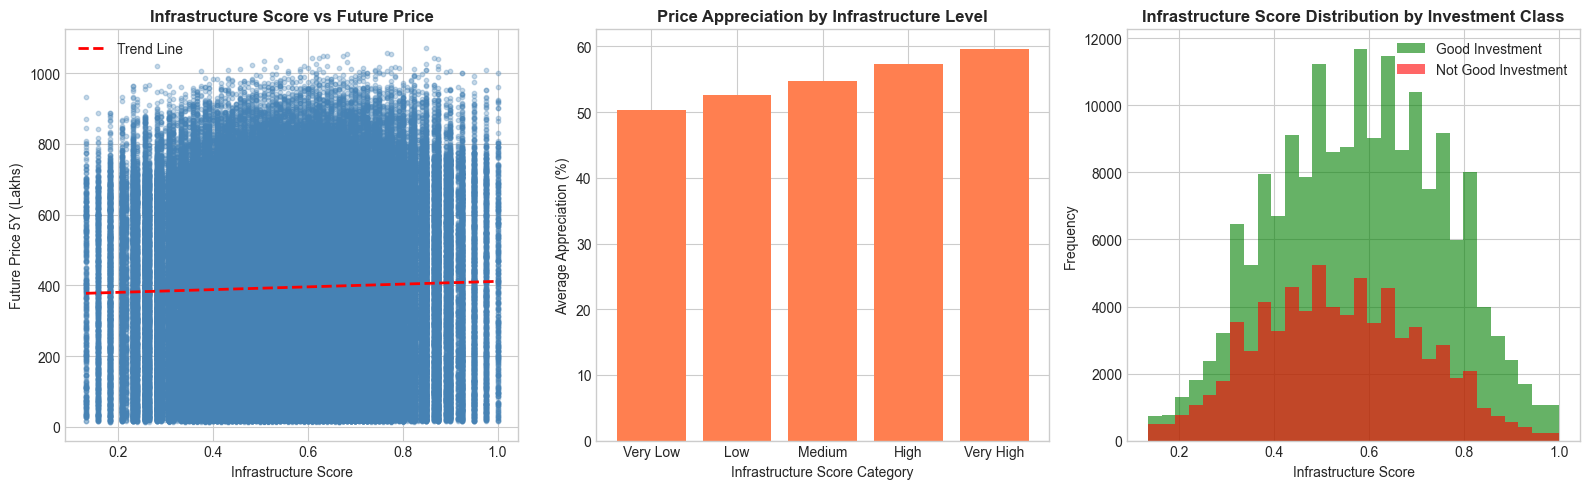

STATISTICAL ANALYSIS: Infrastructure vs Investment

Mean Infrastructure Score - Good Investment: 0.5791
Mean Infrastructure Score - Not Good Investment: 0.5373

T-Test: t-statistic = 54.6088, p-value = 0.000000
→ Statistically significant difference (p < 0.05)


In [19]:
# ============================================================
# INFRASTRUCTURE SCORE VS RESALE VALUE
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Infrastructure Score vs Future Price
axes[0].scatter(df['Infrastructure_Score'], df['Future_Price_5Y'], alpha=0.3, s=10, c='steelblue')
axes[0].set_xlabel('Infrastructure Score')
axes[0].set_ylabel('Future Price 5Y (Lakhs)')
axes[0].set_title('Infrastructure Score vs Future Price', fontsize=12, fontweight='bold')

# Add regression line
z = np.polyfit(df['Infrastructure_Score'], df['Future_Price_5Y'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['Infrastructure_Score'].min(), df['Infrastructure_Score'].max(), 100)
axes[0].plot(x_line, p(x_line), "r--", linewidth=2, label='Trend Line')
axes[0].legend()

# 2. Infrastructure Score Bins vs Appreciation
df['Infra_Bin'] = pd.cut(df['Infrastructure_Score'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
infra_appreciation = df.groupby('Infra_Bin')['Appreciation_Percent'].mean()
axes[1].bar(infra_appreciation.index, infra_appreciation.values, color='coral')
axes[1].set_xlabel('Infrastructure Score Category')
axes[1].set_ylabel('Average Appreciation (%)')
axes[1].set_title('Price Appreciation by Infrastructure Level', fontsize=12, fontweight='bold')

# 3. Infrastructure Score Distribution for Good vs Bad Investment
good_inv = df[df['Good_Investment'] == 1]['Infrastructure_Score']
bad_inv = df[df['Good_Investment'] == 0]['Infrastructure_Score']

axes[2].hist(good_inv, bins=30, alpha=0.6, label='Good Investment', color='green')
axes[2].hist(bad_inv, bins=30, alpha=0.6, label='Not Good Investment', color='red')
axes[2].set_xlabel('Infrastructure Score')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Infrastructure Score Distribution by Investment Class', fontsize=12, fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

# Statistical Analysis
print("=" * 60)
print("STATISTICAL ANALYSIS: Infrastructure vs Investment")
print("=" * 60)
print(f"\nMean Infrastructure Score - Good Investment: {good_inv.mean():.4f}")
print(f"Mean Infrastructure Score - Not Good Investment: {bad_inv.mean():.4f}")

# T-test
t_stat, p_value = stats.ttest_ind(good_inv, bad_inv)
print(f"\nT-Test: t-statistic = {t_stat:.4f}, p-value = {p_value:.6f}")
if p_value < 0.05:
    print("→ Statistically significant difference (p < 0.05)")
else:
    print("→ No statistically significant difference (p >= 0.05)")

### 4.5 Interactive Visualizations with Plotly

In [20]:
# ============================================================
# INTERACTIVE VISUALIZATIONS
# ============================================================

# 1. Interactive Price Distribution by City
city_stats = df.groupby('City').agg({
    'Price_in_Lakhs': ['mean', 'median', 'count'],
    'Future_Price_5Y': 'mean',
    'Good_Investment': 'mean'
}).round(2)
city_stats.columns = ['Avg_Price', 'Median_Price', 'Count', 'Avg_Future_Price', 'Good_Inv_Rate']
city_stats = city_stats.reset_index()
city_stats = city_stats[city_stats['Count'] > 100].sort_values('Avg_Price', ascending=False).head(20)

fig = px.bar(city_stats, x='City', y='Avg_Price', 
             color='Good_Inv_Rate',
             color_continuous_scale='RdYlGn',
             hover_data=['Median_Price', 'Count', 'Avg_Future_Price', 'Good_Inv_Rate'],
             title='Average Property Price by City (Color: Good Investment Rate)')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [21]:
# 2. Sunburst Chart: State -> City -> Property Type
# Sample data for better visualization
df_sample = df.sample(n=min(10000, len(df)), random_state=42)

fig = px.sunburst(df_sample, path=['State', 'City', 'Property_Type'], 
                  values='Price_in_Lakhs',
                  color='Good_Investment',
                  color_continuous_scale='RdYlGn',
                  title='Property Distribution: State → City → Type (Size: Price, Color: Good Investment)')
fig.show()

## 5. Prepare Data for Modeling

In [39]:
# ============================================================
# PREPARE DATA FOR MODELING
# ============================================================

# IMPORTANT: Different features for Classification vs Regression to avoid DATA LEAKAGE!
# 
# For Classification (Good Investment):
#   - EXCLUDE Price_in_Lakhs because Good_Investment is CALCULATED from price!
#   - Using price to predict something derived from price = 100% accuracy (cheating)
#
# For Regression (Future Price):
#   - Include Price_in_Lakhs as it's a legitimate predictor of future price

# Features for CLASSIFICATION (no price - would cause data leakage!)
clf_features = [
    'BHK', 'Size_in_SqFt', 'Year_Built', 'Floor_No', 
    'Total_Floors', 'Age_of_Property', 'Nearby_Schools', 'Nearby_Hospitals',
    'Transport_Score', 'Infrastructure_Score', 'Is_Ready_to_Move', 
    'Has_Parking', 'Has_Security', 'Amenities_Count', 'Location_Premium_Score',
    'State_Encoded', 'City_Encoded', 'Property_Type_Encoded', 
    'Furnished_Status_Encoded', 'Owner_Type_Encoded'
]

# Features for REGRESSION (price included - legitimate for predicting future price)
reg_features = [
    'BHK', 'Size_in_SqFt', 'Price_in_Lakhs', 'Year_Built', 'Floor_No', 
    'Total_Floors', 'Age_of_Property', 'Nearby_Schools', 'Nearby_Hospitals',
    'Transport_Score', 'Infrastructure_Score', 'Is_Ready_to_Move', 
    'Has_Parking', 'Has_Security', 'Amenities_Count', 'Location_Premium_Score',
    'State_Encoded', 'City_Encoded', 'Property_Type_Encoded', 
    'Furnished_Status_Encoded', 'Owner_Type_Encoded'
]

# Ensure all columns exist
clf_features = [col for col in clf_features if col in df.columns]
reg_features = [col for col in reg_features if col in df.columns]

print("=" * 60)
print("FEATURE SELECTION FOR MODELING")
print("=" * 60)

print(f"\n📊 CLASSIFICATION Features ({len(clf_features)}) - NO PRICE (avoids data leakage):")
for i, feat in enumerate(clf_features, 1):
    print(f"  {i}. {feat}")

print(f"\n📈 REGRESSION Features ({len(reg_features)}) - WITH PRICE:")
for i, feat in enumerate(reg_features, 1):
    print(f"  {i}. {feat}")

# Create feature matrices
X_clf = df[clf_features].copy()
X_reg = df[reg_features].copy()

# Create target variables
y_classification = df['Good_Investment'].copy()
y_regression = df['Future_Price_5Y'].copy()

print(f"\n✅ Classification Feature Matrix Shape: {X_clf.shape}")
print(f"✅ Regression Feature Matrix Shape: {X_reg.shape}")
print(f"✅ Classification Target Shape: {y_classification.shape}")
print(f"✅ Regression Target Shape: {y_regression.shape}")

# Keep model_features for backward compatibility (use clf_features as default)
model_features = clf_features

FEATURE SELECTION FOR MODELING

📊 CLASSIFICATION Features (20) - NO PRICE (avoids data leakage):
  1. BHK
  2. Size_in_SqFt
  3. Year_Built
  4. Floor_No
  5. Total_Floors
  6. Age_of_Property
  7. Nearby_Schools
  8. Nearby_Hospitals
  9. Transport_Score
  10. Infrastructure_Score
  11. Is_Ready_to_Move
  12. Has_Parking
  13. Has_Security
  14. Amenities_Count
  15. Location_Premium_Score
  16. State_Encoded
  17. City_Encoded
  18. Property_Type_Encoded
  19. Furnished_Status_Encoded
  20. Owner_Type_Encoded

📈 REGRESSION Features (21) - WITH PRICE:
  1. BHK
  2. Size_in_SqFt
  3. Price_in_Lakhs
  4. Year_Built
  5. Floor_No
  6. Total_Floors
  7. Age_of_Property
  8. Nearby_Schools
  9. Nearby_Hospitals
  10. Transport_Score
  11. Infrastructure_Score
  12. Is_Ready_to_Move
  13. Has_Parking
  14. Has_Security
  15. Amenities_Count
  16. Location_Premium_Score
  17. State_Encoded
  18. City_Encoded
  19. Property_Type_Encoded
  20. Furnished_Status_Encoded
  21. Owner_Type_Encoded


In [40]:
# Split data for Classification (using clf_features - NO PRICE)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

# Split data for Regression (using reg_features - WITH PRICE)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_regression, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_clf_scaled = scaler.fit_transform(X_train_clf)
X_test_clf_scaled = scaler.transform(X_test_clf)
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

print("=" * 60)
print("DATA SPLIT SUMMARY")
print("=" * 60)
print(f"\n📊 Classification Split (NO PRICE features):")
print(f"  Training set: {X_train_clf.shape[0]} samples, {X_train_clf.shape[1]} features")
print(f"  Test set: {X_test_clf.shape[0]} samples, {X_test_clf.shape[1]} features")
print(f"  Good Investment ratio (train): {y_train_clf.mean():.2%}")
print(f"  Good Investment ratio (test): {y_test_clf.mean():.2%}")

print(f"\n📈 Regression Split (WITH PRICE features):")
print(f"  Training set: {X_train_reg.shape[0]} samples, {X_train_reg.shape[1]} features")
print(f"  Test set: {X_test_reg.shape[0]} samples, {X_test_reg.shape[1]} features")

DATA SPLIT SUMMARY

📊 Classification Split (NO PRICE features):
  Training set: 200000 samples, 20 features
  Test set: 50000 samples, 20 features
  Good Investment ratio (train): 70.94%
  Good Investment ratio (test): 70.94%

📈 Regression Split (WITH PRICE features):
  Training set: 200000 samples, 21 features
  Test set: 50000 samples, 21 features


## 6. MLflow Setup for Experiment Tracking

In [24]:
# ============================================================
# MLFLOW SETUP
# ============================================================

# Set MLflow tracking URI (local file-based tracking)
mlflow.set_tracking_uri("mlruns")

# Create or set experiment
experiment_name = "Real_Estate_Investment_Advisor"
mlflow.set_experiment(experiment_name)

print("=" * 60)
print("MLFLOW CONFIGURATION")
print("=" * 60)
print(f"\nExperiment Name: {experiment_name}")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"\nMLflow is ready for experiment tracking!")
print("To view the MLflow UI, run: mlflow ui")

2025/12/02 14:59:10 INFO mlflow.tracking.fluent: Experiment with name 'Real_Estate_Investment_Advisor' does not exist. Creating a new experiment.


MLFLOW CONFIGURATION

Experiment Name: Real_Estate_Investment_Advisor
Tracking URI: mlruns

MLflow is ready for experiment tracking!
To view the MLflow UI, run: mlflow ui


## 7. Classification Model Development

### 7.1 Train Multiple Classification Models

In [41]:
# ============================================================
# CLASSIFICATION MODELS - TRAINING
# ============================================================

# Define classification models
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, 
                             eval_metric='logloss', verbosity=0)
}

# Store results
classification_results = {}
trained_clf_models = {}

print("=" * 60)
print("TRAINING CLASSIFICATION MODELS")
print("=" * 60)

for name, model in classification_models.items():
    print(f"\n→ Training {name}...")
    
    # Start MLflow run
    with mlflow.start_run(run_name=f"Classification_{name.replace(' ', '_')}"):
        # Train model
        if name == 'Logistic Regression':
            model.fit(X_train_clf_scaled, y_train_clf)
            y_pred = model.predict(X_test_clf_scaled)
            y_pred_proba = model.predict_proba(X_test_clf_scaled)[:, 1]
        else:
            model.fit(X_train_clf, y_train_clf)
            y_pred = model.predict(X_test_clf)
            y_pred_proba = model.predict_proba(X_test_clf)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test_clf, y_pred)
        precision = precision_score(y_test_clf, y_pred)
        recall = recall_score(y_test_clf, y_pred)
        f1 = f1_score(y_test_clf, y_pred)
        roc_auc = roc_auc_score(y_test_clf, y_pred_proba)
        
        # Store results
        classification_results[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'ROC AUC': roc_auc
        }
        trained_clf_models[name] = model
        
        # Log to MLflow
        mlflow.log_param("model_type", name)
        mlflow.log_param("task", "classification")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)
        
        # Log model
        if name == 'XGBoost':
            mlflow.xgboost.log_model(model, f"model_{name.replace(' ', '_')}")
        else:
            mlflow.sklearn.log_model(model, f"model_{name.replace(' ', '_')}")
        
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  ROC AUC: {roc_auc:.4f}")

print("\n✓ All classification models trained and logged to MLflow!")

TRAINING CLASSIFICATION MODELS

→ Training Logistic Regression...


2025/12/02 19:17:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 19:17:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/02 19:17:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Accuracy: 0.7130
  ROC AUC: 0.7095

→ Training Random Forest...


2025/12/02 19:17:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 19:17:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/02 19:17:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Accuracy: 0.7083
  ROC AUC: 0.7239

→ Training Gradient Boosting...


2025/12/02 19:18:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 19:18:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/02 19:18:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Accuracy: 0.7138
  ROC AUC: 0.7294

→ Training XGBoost...


2025/12/02 19:18:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 19:18:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/02 19:18:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Accuracy: 0.7087
  ROC AUC: 0.7264

✓ All classification models trained and logged to MLflow!


### 7.2 Classification Model Evaluation

In [26]:
# ============================================================
# CLASSIFICATION MODEL COMPARISON
# ============================================================

# Create comparison dataframe
clf_comparison_df = pd.DataFrame(classification_results).T
clf_comparison_df = clf_comparison_df.round(4)

print("=" * 60)
print("CLASSIFICATION MODEL COMPARISON")
print("=" * 60)
print(clf_comparison_df)

# Find best model
best_clf_model_name = clf_comparison_df['ROC AUC'].idxmax()
print(f"\n✓ Best Classification Model: {best_clf_model_name}")
print(f"  ROC AUC: {clf_comparison_df.loc[best_clf_model_name, 'ROC AUC']:.4f}")

CLASSIFICATION MODEL COMPARISON
                     Accuracy  Precision  Recall  F1 Score  ROC AUC
Logistic Regression    0.9234     0.9429  0.9495    0.9462   0.9775
Random Forest          0.9800     0.9838  0.9881    0.9860   0.9983
Gradient Boosting      0.9711     0.9786  0.9807    0.9797   0.9959
XGBoost                0.9900     0.9926  0.9934    0.9930   0.9995

✓ Best Classification Model: XGBoost
  ROC AUC: 0.9995


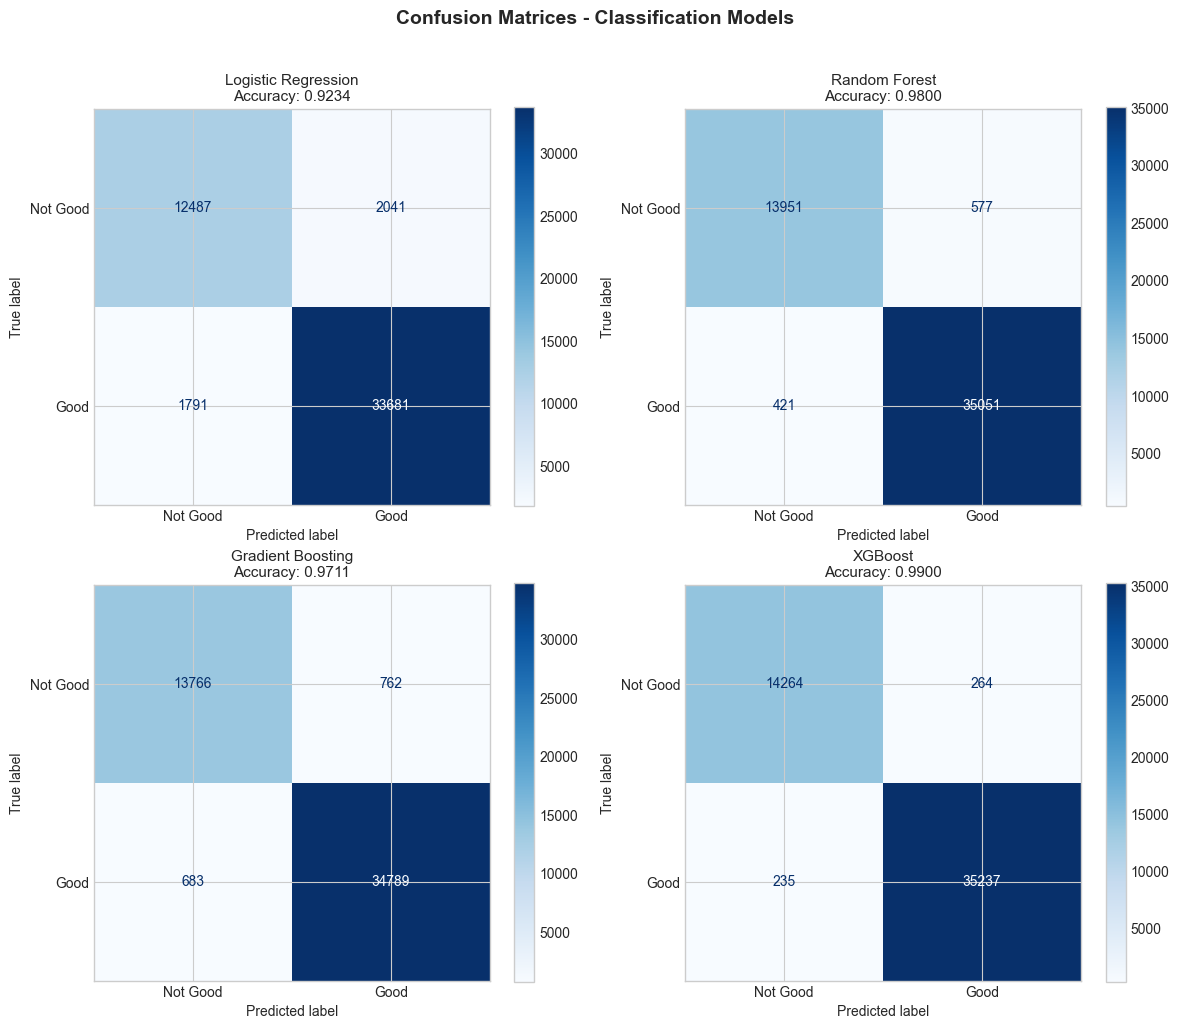

In [27]:
# ============================================================
# CONFUSION MATRICES
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(trained_clf_models.items()):
    if name == 'Logistic Regression':
        y_pred = model.predict(X_test_clf_scaled)
    else:
        y_pred = model.predict(X_test_clf)
    
    cm = confusion_matrix(y_test_clf, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Good', 'Good'])
    disp.plot(ax=axes[idx], cmap='Blues')
    axes[idx].set_title(f'{name}\nAccuracy: {accuracy_score(y_test_clf, y_pred):.4f}', fontsize=11)

plt.suptitle('Confusion Matrices - Classification Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

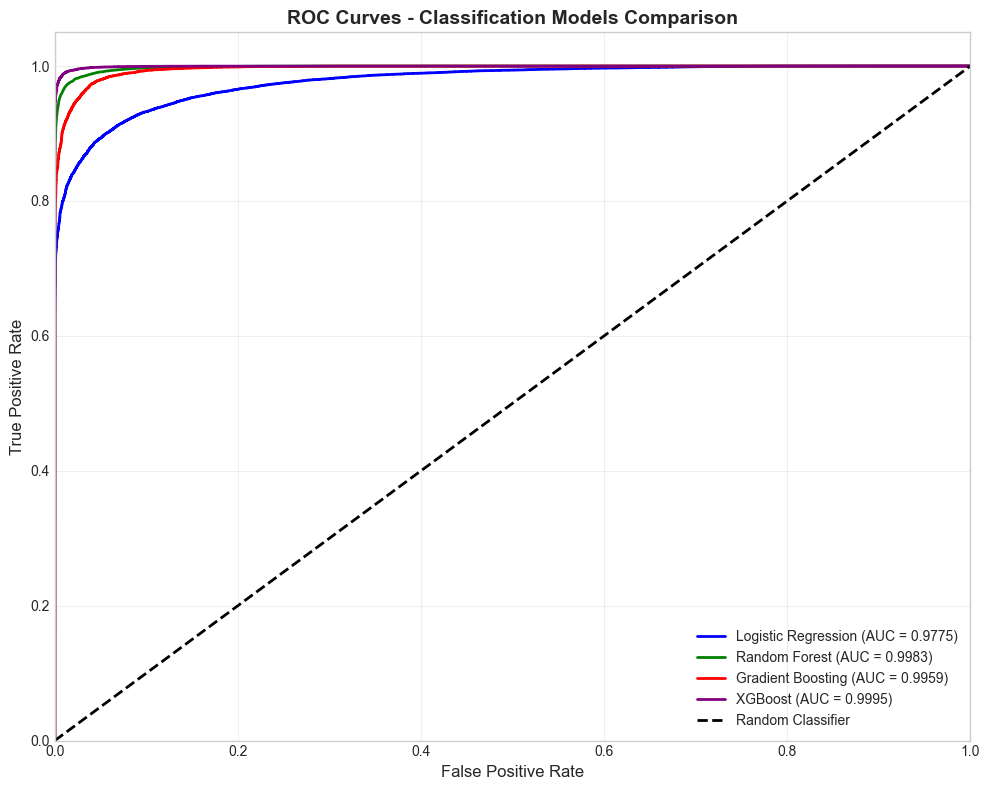

In [28]:
# ============================================================
# ROC CURVES COMPARISON
# ============================================================

plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red', 'purple']
for idx, (name, model) in enumerate(trained_clf_models.items()):
    if name == 'Logistic Regression':
        y_pred_proba = model.predict_proba(X_test_clf_scaled)[:, 1]
    else:
        y_pred_proba = model.predict_proba(X_test_clf)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test_clf, y_pred_proba)
    auc = roc_auc_score(y_test_clf, y_pred_proba)
    plt.plot(fpr, tpr, color=colors[idx], lw=2, label=f'{name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Classification Models Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Regression Model Development

### 8.1 Train Multiple Regression Models

In [42]:
# ============================================================
# REGRESSION MODELS - TRAINING
# ============================================================

# Define regression models
regression_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# Store results
regression_results = {}
trained_reg_models = {}

print("=" * 60)
print("TRAINING REGRESSION MODELS")
print("=" * 60)

for name, model in regression_models.items():
    print(f"\n→ Training {name}...")
    
    # Start MLflow run
    with mlflow.start_run(run_name=f"Regression_{name.replace(' ', '_')}"):
        # Train model
        if name == 'Linear Regression':
            model.fit(X_train_reg_scaled, y_train_reg)
            y_pred = model.predict(X_test_reg_scaled)
        else:
            model.fit(X_train_reg, y_train_reg)
            y_pred = model.predict(X_test_reg)
        
        # Calculate metrics
        mse = mean_squared_error(y_test_reg, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_reg, y_pred)
        r2 = r2_score(y_test_reg, y_pred)
        
        # Store results
        regression_results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R² Score': r2,
            'MSE': mse
        }
        trained_reg_models[name] = model
        
        # Log to MLflow
        mlflow.log_param("model_type", name)
        mlflow.log_param("task", "regression")
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2_score", r2)
        mlflow.log_metric("mse", mse)
        
        # Log model
        if name == 'XGBoost':
            mlflow.xgboost.log_model(model, f"model_{name.replace(' ', '_')}")
        else:
            mlflow.sklearn.log_model(model, f"model_{name.replace(' ', '_')}")
        
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R² Score: {r2:.4f}")

print("\n✓ All regression models trained and logged to MLflow!")

TRAINING REGRESSION MODELS

→ Training Linear Regression...


2025/12/02 19:18:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 19:18:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/02 19:18:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  RMSE: 37.4001
  R² Score: 0.9718

→ Training Random Forest...


2025/12/02 19:18:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 19:18:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/02 19:18:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  RMSE: 3.4762
  R² Score: 0.9998

→ Training Gradient Boosting...


2025/12/02 19:19:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 19:19:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/02 19:19:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  RMSE: 17.1505
  R² Score: 0.9941

→ Training XGBoost...


2025/12/02 19:19:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 19:19:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/02 19:19:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  RMSE: 4.2183
  R² Score: 0.9996

✓ All regression models trained and logged to MLflow!


### 8.2 Regression Model Evaluation

In [30]:
# ============================================================
# REGRESSION MODEL COMPARISON
# ============================================================

# Create comparison dataframe
reg_comparison_df = pd.DataFrame(regression_results).T
reg_comparison_df = reg_comparison_df.round(4)

print("=" * 60)
print("REGRESSION MODEL COMPARISON")
print("=" * 60)
print(reg_comparison_df)

# Find best model
best_reg_model_name = reg_comparison_df['R² Score'].idxmax()
print(f"\n✓ Best Regression Model: {best_reg_model_name}")
print(f"  R² Score: {reg_comparison_df.loc[best_reg_model_name, 'R² Score']:.4f}")
print(f"  RMSE: {reg_comparison_df.loc[best_reg_model_name, 'RMSE']:.4f}")

REGRESSION MODEL COMPARISON
                      RMSE      MAE  R² Score        MSE
Linear Regression  37.4001  25.5630    0.9718  1398.7661
Random Forest       3.4762   2.2113    0.9998    12.0838
Gradient Boosting  17.1505  11.4037    0.9941   294.1382
XGBoost             4.2183   3.0118    0.9996    17.7944

✓ Best Regression Model: Random Forest
  R² Score: 0.9998
  RMSE: 3.4762


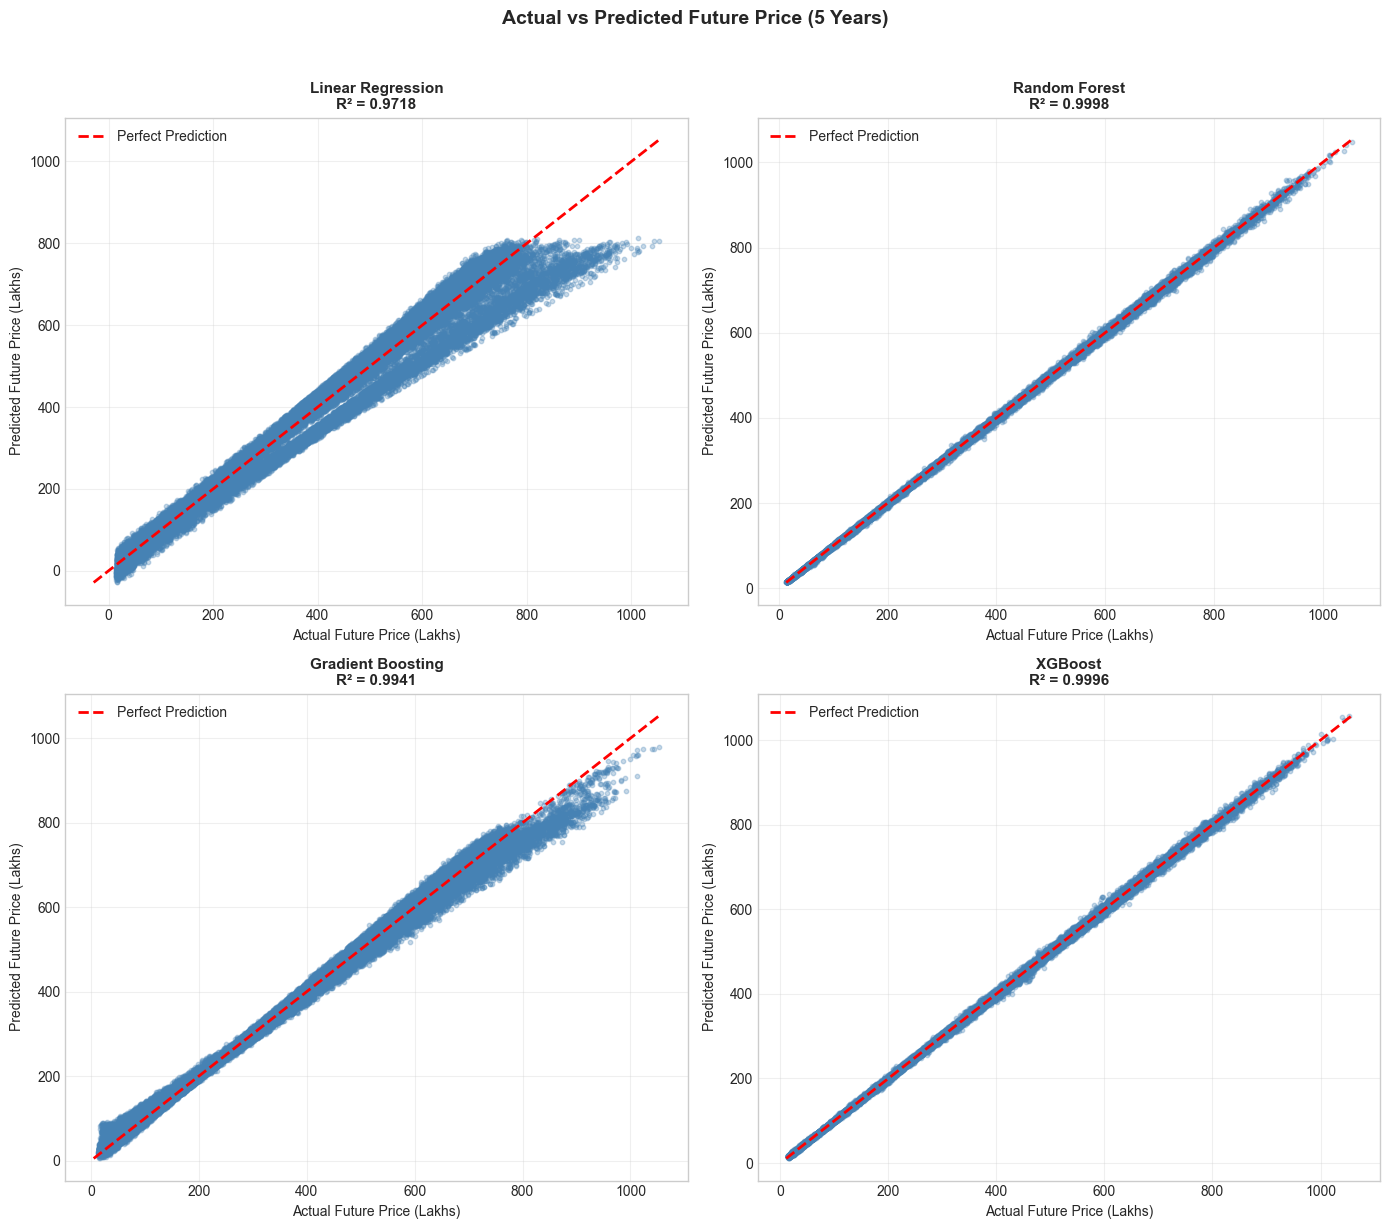

In [31]:
# ============================================================
# ACTUAL VS PREDICTED PLOTS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (name, model) in enumerate(trained_reg_models.items()):
    if name == 'Linear Regression':
        y_pred = model.predict(X_test_reg_scaled)
    else:
        y_pred = model.predict(X_test_reg)
    
    axes[idx].scatter(y_test_reg, y_pred, alpha=0.3, s=10, c='steelblue')
    
    # Perfect prediction line
    max_val = max(y_test_reg.max(), y_pred.max())
    min_val = min(y_test_reg.min(), y_pred.min())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual Future Price (Lakhs)', fontsize=10)
    axes[idx].set_ylabel('Predicted Future Price (Lakhs)', fontsize=10)
    r2 = r2_score(y_test_reg, y_pred)
    axes[idx].set_title(f'{name}\nR² = {r2:.4f}', fontsize=11, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Actual vs Predicted Future Price (5 Years)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

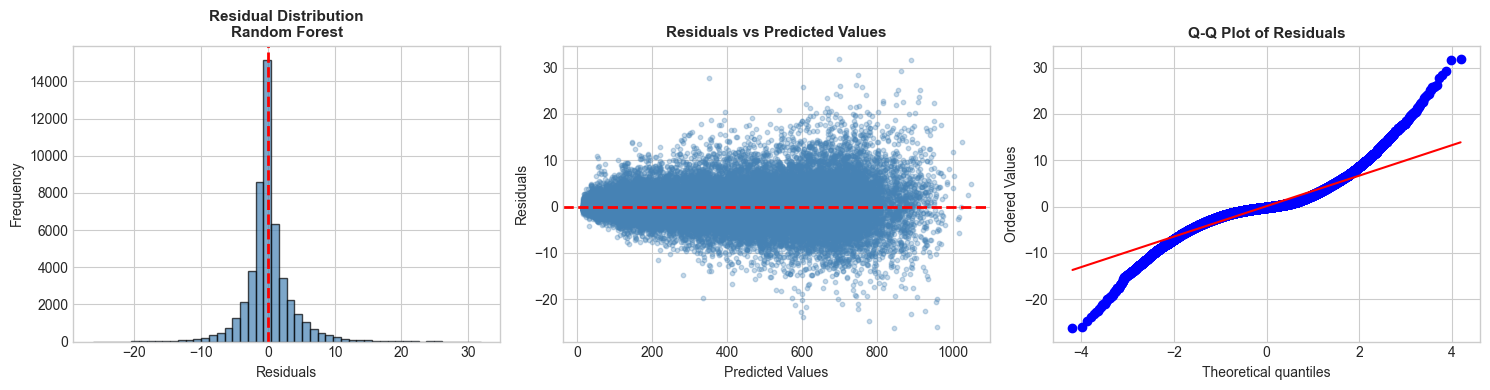

Residual Statistics for Random Forest:
  Mean: 0.0776
  Std: 3.4753
  Skewness: 0.6632


In [32]:
# ============================================================
# RESIDUAL ANALYSIS FOR BEST MODEL
# ============================================================

# Get predictions from best model
best_reg_model = trained_reg_models[best_reg_model_name]
if best_reg_model_name == 'Linear Regression':
    y_pred_best = best_reg_model.predict(X_test_reg_scaled)
else:
    y_pred_best = best_reg_model.predict(X_test_reg)

residuals = y_test_reg - y_pred_best

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Residual distribution
axes[0].hist(residuals, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Residual Distribution\n{best_reg_model_name}', fontsize=11, fontweight='bold')

# 2. Residuals vs Predicted
axes[1].scatter(y_pred_best, residuals, alpha=0.3, s=10, c='steelblue')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals vs Predicted Values', fontsize=11, fontweight='bold')

# 3. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot of Residuals', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Residual Statistics for {best_reg_model_name}:")
print(f"  Mean: {residuals.mean():.4f}")
print(f"  Std: {residuals.std():.4f}")
print(f"  Skewness: {stats.skew(residuals):.4f}")

## 9. Feature Importance Analysis

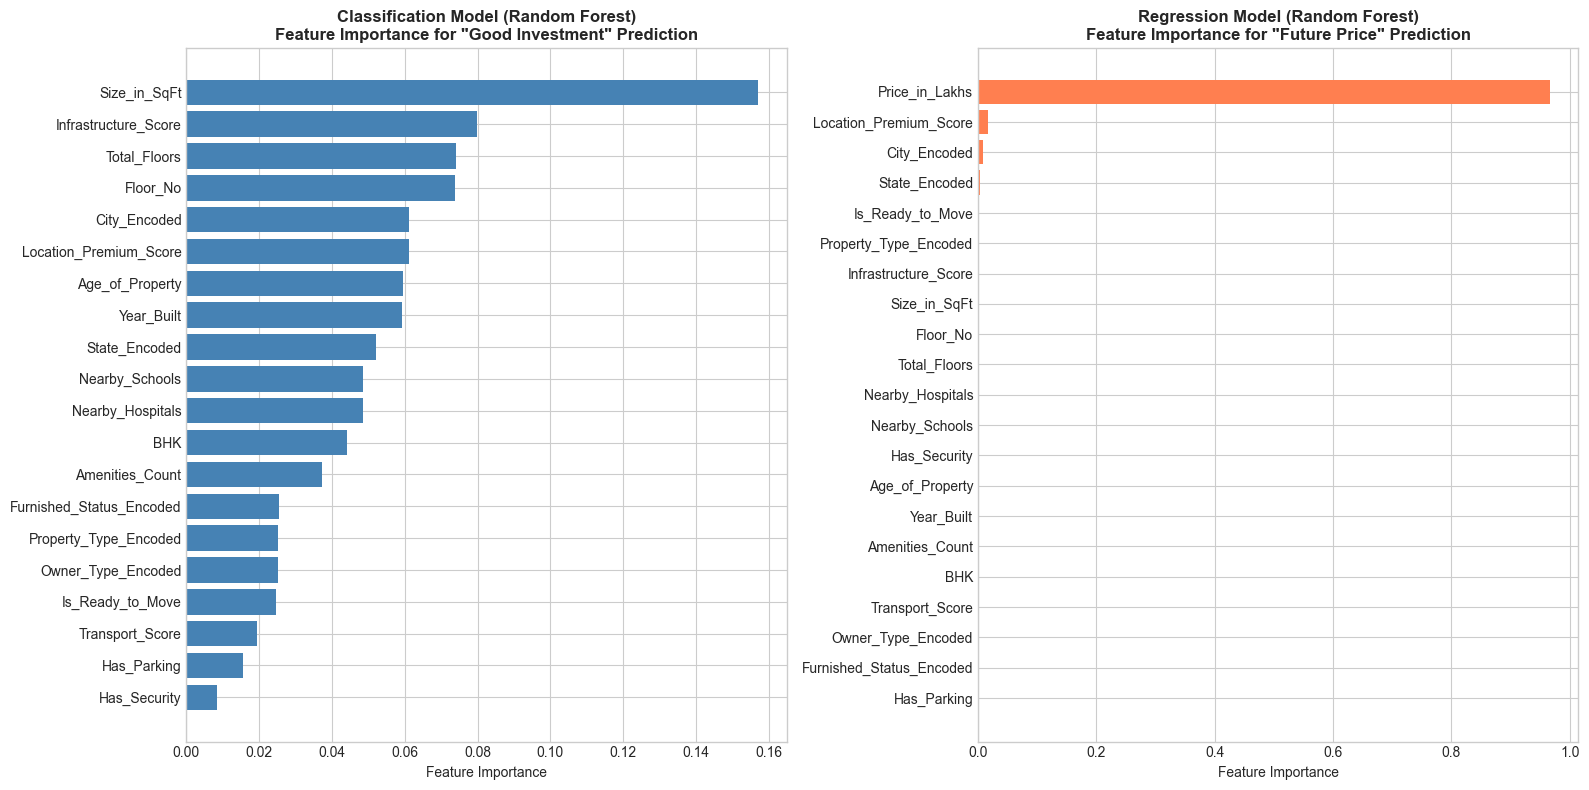

TOP 10 FEATURES

For Classification (Good Investment) - NO Price feature:
  Size_in_SqFt: 0.1571
  Infrastructure_Score: 0.0799
  Total_Floors: 0.0740
  Floor_No: 0.0738
  City_Encoded: 0.0613
  Location_Premium_Score: 0.0610
  Age_of_Property: 0.0595
  Year_Built: 0.0593
  State_Encoded: 0.0520
  Nearby_Schools: 0.0485

For Regression (Future Price) - WITH Price feature:
  Price_in_Lakhs: 0.9663
  Location_Premium_Score: 0.0167
  City_Encoded: 0.0087
  State_Encoded: 0.0032
  Is_Ready_to_Move: 0.0021
  Property_Type_Encoded: 0.0017
  Infrastructure_Score: 0.0010
  Size_in_SqFt: 0.0000
  Floor_No: 0.0000
  Total_Floors: 0.0000


In [44]:
# ============================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Classification Feature Importance (Random Forest) - uses clf_features (NO PRICE)
rf_clf = trained_clf_models['Random Forest']
clf_importance = pd.DataFrame({
    'Feature': clf_features,
    'Importance': rf_clf.feature_importances_
}).sort_values('Importance', ascending=True)

axes[0].barh(clf_importance['Feature'], clf_importance['Importance'], color='steelblue')
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('Classification Model (Random Forest)\nFeature Importance for "Good Investment" Prediction', 
                   fontsize=12, fontweight='bold')

# Regression Feature Importance (Random Forest) - uses reg_features (WITH PRICE)
rf_reg = trained_reg_models['Random Forest']
reg_importance = pd.DataFrame({
    'Feature': reg_features,
    'Importance': rf_reg.feature_importances_
}).sort_values('Importance', ascending=True)

axes[1].barh(reg_importance['Feature'], reg_importance['Importance'], color='coral')
axes[1].set_xlabel('Feature Importance')
axes[1].set_title('Regression Model (Random Forest)\nFeature Importance for "Future Price" Prediction', 
                   fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print top features
print("=" * 60)
print("TOP 10 FEATURES")
print("=" * 60)
print("\nFor Classification (Good Investment) - NO Price feature:")
for i, row in clf_importance.tail(10).iloc[::-1].iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")

print("\nFor Regression (Future Price) - WITH Price feature:")
for i, row in reg_importance.tail(10).iloc[::-1].iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")

## 10. Hyperparameter Tuning for Best Models

In [45]:
# ============================================================
# HYPERPARAMETER TUNING - XGBOOST CLASSIFIER
# ============================================================

print("=" * 60)
print("HYPERPARAMETER TUNING - XGBoost Classifier")
print("=" * 60)

# Define parameter grid
param_grid_clf = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize XGBoost Classifier
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', verbosity=0)

# Grid Search with Cross-Validation
print("\nPerforming Grid Search (this may take a few minutes)...")
grid_search_clf = GridSearchCV(
    xgb_clf, param_grid_clf, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1
)
grid_search_clf.fit(X_train_clf, y_train_clf)

print(f"\nBest Parameters: {grid_search_clf.best_params_}")
print(f"Best CV ROC AUC: {grid_search_clf.best_score_:.4f}")

# Evaluate on test set
best_clf_model = grid_search_clf.best_estimator_
y_pred_clf = best_clf_model.predict(X_test_clf)
y_pred_proba_clf = best_clf_model.predict_proba(X_test_clf)[:, 1]

print(f"\nTest Set Performance:")
print(f"  Accuracy: {accuracy_score(y_test_clf, y_pred_clf):.4f}")
print(f"  ROC AUC: {roc_auc_score(y_test_clf, y_pred_proba_clf):.4f}")

HYPERPARAMETER TUNING - XGBoost Classifier

Performing Grid Search (this may take a few minutes)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV ROC AUC: 0.7364

Test Set Performance:
  Accuracy: 0.7155
  ROC AUC: 0.7328

Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV ROC AUC: 0.7364

Test Set Performance:
  Accuracy: 0.7155
  ROC AUC: 0.7328


In [46]:
# ============================================================
# HYPERPARAMETER TUNING - XGBOOST REGRESSOR
# ============================================================

print("=" * 60)
print("HYPERPARAMETER TUNING - XGBoost Regressor")
print("=" * 60)

# Define parameter grid
param_grid_reg = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize XGBoost Regressor
xgb_reg = XGBRegressor(random_state=42, verbosity=0)

# Grid Search with Cross-Validation
print("\nPerforming Grid Search (this may take a few minutes)...")
grid_search_reg = GridSearchCV(
    xgb_reg, param_grid_reg, cv=3, scoring='r2', n_jobs=-1, verbose=1
)
grid_search_reg.fit(X_train_reg, y_train_reg)

print(f"\nBest Parameters: {grid_search_reg.best_params_}")
print(f"Best CV R² Score: {grid_search_reg.best_score_:.4f}")

# Evaluate on test set
best_reg_model = grid_search_reg.best_estimator_
y_pred_reg = best_reg_model.predict(X_test_reg)

print(f"\nTest Set Performance:")
print(f"  R² Score: {r2_score(y_test_reg, y_pred_reg):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)):.4f}")
print(f"  MAE: {mean_absolute_error(y_test_reg, y_pred_reg):.4f}")

HYPERPARAMETER TUNING - XGBoost Regressor

Performing Grid Search (this may take a few minutes)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best CV R² Score: 0.9998

Test Set Performance:
  R² Score: 0.9998
  RMSE: 2.7794
  MAE: 1.9989

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best CV R² Score: 0.9998

Test Set Performance:
  R² Score: 0.9998
  RMSE: 2.7794
  MAE: 1.9989


## 11. MLflow Model Registry - Register Best Models

In [47]:
# ============================================================
# MLFLOW MODEL REGISTRY
# ============================================================

print("=" * 60)
print("REGISTERING BEST MODELS TO MLFLOW")
print("=" * 60)

# Register tuned Classification Model
with mlflow.start_run(run_name="Best_Classification_Model_Tuned"):
    mlflow.log_params(grid_search_clf.best_params_)
    mlflow.log_metric("accuracy", accuracy_score(y_test_clf, y_pred_clf))
    mlflow.log_metric("roc_auc", roc_auc_score(y_test_clf, y_pred_proba_clf))
    mlflow.log_metric("precision", precision_score(y_test_clf, y_pred_clf))
    mlflow.log_metric("recall", recall_score(y_test_clf, y_pred_clf))
    
    # Log model
    mlflow.xgboost.log_model(
        best_clf_model, 
        "best_classification_model",
        registered_model_name="RealEstate_GoodInvestment_Classifier"
    )
    print("✓ Classification model registered: RealEstate_GoodInvestment_Classifier")

# Register tuned Regression Model
with mlflow.start_run(run_name="Best_Regression_Model_Tuned"):
    mlflow.log_params(grid_search_reg.best_params_)
    mlflow.log_metric("r2_score", r2_score(y_test_reg, y_pred_reg))
    mlflow.log_metric("rmse", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
    mlflow.log_metric("mae", mean_absolute_error(y_test_reg, y_pred_reg))
    
    # Log model
    mlflow.xgboost.log_model(
        best_reg_model, 
        "best_regression_model",
        registered_model_name="RealEstate_FuturePrice_Regressor"
    )
    print("✓ Regression model registered: RealEstate_FuturePrice_Regressor")

print("\n✓ All best models registered to MLflow Model Registry!")

2025/12/02 19:21:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


REGISTERING BEST MODELS TO MLFLOW


2025/12/02 19:21:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RealEstate_GoodInvestment_Classifier' already exists. Creating a new version of this model...
Created version '2' of model 'RealEstate_GoodInvestment_Classifier'.
Registered model 'RealEstate_GoodInvestment_Classifier' already exists. Creating a new version of this model...
Created version '2' of model 'RealEstate_GoodInvestment_Classifier'.
2025/12/02 19:21:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 19:21:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Classification model registered: RealEstate_GoodInvestment_Classifier


2025/12/02 19:21:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✓ Regression model registered: RealEstate_FuturePrice_Regressor

✓ All best models registered to MLflow Model Registry!


Registered model 'RealEstate_FuturePrice_Regressor' already exists. Creating a new version of this model...
Created version '2' of model 'RealEstate_FuturePrice_Regressor'.


## 12. Save Models and Artifacts for Flask Deployment

In [ ]:
# ============================================================
# SAVE MODELS AND ARTIFACTS FOR FLASK APP
# ============================================================

# Create models directory
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

print("=" * 60)
print("SAVING MODELS AND ARTIFACTS")
print("=" * 60)

# Save Classification Model
joblib.dump(best_clf_model, f'{models_dir}/classification_model.joblib')
print(f"✓ Saved: {models_dir}/classification_model.joblib")

# Save Regression Model
joblib.dump(best_reg_model, f'{models_dir}/regression_model.joblib')
print(f"✓ Saved: {models_dir}/regression_model.joblib")

# Save Scaler
joblib.dump(scaler, f'{models_dir}/scaler.joblib')
print(f"✓ Saved: {models_dir}/scaler.joblib")

# Save Label Encoders
with open(f'{models_dir}/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"✓ Saved: {models_dir}/label_encoders.pkl")

# Save Feature Names - SEPARATE FOR CLASSIFICATION AND REGRESSION
# Classification features (NO PRICE - avoids data leakage)
with open(f'{models_dir}/clf_feature_names.pkl', 'wb') as f:
    pickle.dump(clf_features, f)
print(f"✓ Saved: {models_dir}/clf_feature_names.pkl ({len(clf_features)} features, NO Price)")

# Regression features (WITH PRICE)
with open(f'{models_dir}/reg_feature_names.pkl', 'wb') as f:
    pickle.dump(reg_features, f)
print(f"✓ Saved: {models_dir}/reg_feature_names.pkl ({len(reg_features)} features, WITH Price)")

# Keep backward compatible feature_names.pkl (use clf_features)
with open(f'{models_dir}/feature_names.pkl', 'wb') as f:
    pickle.dump(clf_features, f)
print(f"✓ Saved: {models_dir}/feature_names.pkl (backward compatible)")

# Save City Growth Rates (for future price calculation)
with open(f'{models_dir}/city_growth_rates.pkl', 'wb') as f:
    pickle.dump(city_growth_rates, f)
print(f"✓ Saved: {models_dir}/city_growth_rates.pkl")

# Save unique values for dropdowns in Flask app
dropdown_values = {
    'states': df['State'].unique().tolist(),
    'cities': df['City'].unique().tolist(),
    'property_types': df['Property_Type'].unique().tolist(),
    'furnished_status': df['Furnished_Status'].unique().tolist(),
    'owner_types': df['Owner_Type'].unique().tolist(),
    'availability_status': df['Availability_Status'].unique().tolist(),
    'transport_accessibility': df['Public_Transport_Accessibility'].unique().tolist(),
    'facing': df['Facing'].unique().tolist()
}
with open(f'{models_dir}/dropdown_values.pkl', 'wb') as f:
    pickle.dump(dropdown_values, f)
print(f"✓ Saved: {models_dir}/dropdown_values.pkl")

# Save City-State mapping
city_state_map = df.groupby('City')['State'].first().to_dict()
with open(f'{models_dir}/city_state_map.pkl', 'wb') as f:
    pickle.dump(city_state_map, f)
print(f"✓ Saved: {models_dir}/city_state_map.pkl")

# Save sample data for reference
df.head(100).to_csv(f'{models_dir}/sample_data.csv', index=False)
print(f"✓ Saved: {models_dir}/sample_data.csv")

print(f"\n✓ All models and artifacts saved to '{models_dir}/' directory!")
print(f"\n⚠️  IMPORTANT: Classification model uses {len(clf_features)} features (NO Price)")
print(f"⚠️  IMPORTANT: Regression model uses {len(reg_features)} features (WITH Price)")

SAVING MODELS AND ARTIFACTS
✓ Saved: models/classification_model.joblib
✓ Saved: models/regression_model.joblib
✓ Saved: models/scaler.joblib
✓ Saved: models/label_encoders.pkl
✓ Saved: models/clf_feature_names.pkl (20 features, NO Price)
✓ Saved: models/reg_feature_names.pkl (21 features, WITH Price)
✓ Saved: models/feature_names.pkl (backward compatible)
✓ Saved: models/city_growth_rates.pkl
✓ Saved: models/dropdown_values.pkl
✓ Saved: models/city_state_map.pkl
✓ Saved: models/sample_data.csv

✓ All models and artifacts saved to 'models/' directory!

⚠️  IMPORTANT: Classification model uses 20 features (NO Price)
⚠️  IMPORTANT: Regression model uses 21 features (WITH Price)


: 

## 13. Model Summary and Final Results

In [38]:
# ============================================================
# FINAL SUMMARY
# ============================================================

print("=" * 70)
print(" " * 15 + "REAL ESTATE INVESTMENT ADVISOR")
print(" " * 20 + "MODEL SUMMARY")
print("=" * 70)

print("\n📊 DATASET INFORMATION:")
print(f"   Total Properties: {len(df):,}")
print(f"   Features Used: {len(model_features)}")
print(f"   Good Investments: {df['Good_Investment'].sum():,} ({df['Good_Investment'].mean()*100:.1f}%)")

print("\n🎯 CLASSIFICATION MODEL (Good Investment Prediction):")
print(f"   Model: XGBoost Classifier (Tuned)")
print(f"   Accuracy: {accuracy_score(y_test_clf, y_pred_clf):.4f}")
print(f"   ROC AUC: {roc_auc_score(y_test_clf, y_pred_proba_clf):.4f}")
print(f"   Precision: {precision_score(y_test_clf, y_pred_clf):.4f}")
print(f"   Recall: {recall_score(y_test_clf, y_pred_clf):.4f}")

print("\n📈 REGRESSION MODEL (Future Price Prediction):")
print(f"   Model: XGBoost Regressor (Tuned)")
print(f"   R² Score: {r2_score(y_test_reg, y_pred_reg):.4f}")
print(f"   RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)):.4f} Lakhs")
print(f"   MAE: {mean_absolute_error(y_test_reg, y_pred_reg):.4f} Lakhs")

print("\n📁 SAVED ARTIFACTS:")
print(f"   • Classification Model: models/classification_model.joblib")
print(f"   • Regression Model: models/regression_model.joblib")
print(f"   • Scaler: models/scaler.joblib")
print(f"   • Label Encoders: models/label_encoders.pkl")
print(f"   • Feature Names: models/feature_names.pkl")

print("\n🚀 NEXT STEPS:")
print("   1. Run the Flask app: python app.py")
print("   2. View MLflow experiments: mlflow ui")
print("   3. Access the web interface at: http://localhost:5000")

print("\n" + "=" * 70)
print(" " * 20 + "✓ PROJECT COMPLETE!")
print("=" * 70)

               REAL ESTATE INVESTMENT ADVISOR
                    MODEL SUMMARY

📊 DATASET INFORMATION:
   Total Properties: 250,000
   Features Used: 21
   Good Investments: 177,360 (70.9%)

🎯 CLASSIFICATION MODEL (Good Investment Prediction):
   Model: XGBoost Classifier (Tuned)
   Accuracy: 0.9914
   ROC AUC: 0.9996
   Precision: 0.9937
   Recall: 0.9942

📈 REGRESSION MODEL (Future Price Prediction):
   Model: XGBoost Regressor (Tuned)
   R² Score: 0.9998
   RMSE: 2.7794 Lakhs
   MAE: 1.9989 Lakhs

📁 SAVED ARTIFACTS:
   • Classification Model: models/classification_model.joblib
   • Regression Model: models/regression_model.joblib
   • Scaler: models/scaler.joblib
   • Label Encoders: models/label_encoders.pkl
   • Feature Names: models/feature_names.pkl

🚀 NEXT STEPS:
   1. Run the Flask app: python app.py
   2. View MLflow experiments: mlflow ui
   3. Access the web interface at: http://localhost:5000

                    ✓ PROJECT COMPLETE!
